In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [7]:
df = pd.read_csv("vaccination_tweets.csv").fillna("")
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     11020 non-null  object
 3   user_description  11020 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          11020 non-null  object
 12  source            11020 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [9]:
# No of tweets over the time
fig = px.histogram(df,x='date', nbins=100,hover_data=['date'],opacity=0.6)
fig.update_layout(yaxis_title='Tweet Count', title='Tweets by Date')

In [10]:
px.histogram(df, x="user_verified", color="user_verified", title='Verified Users')

In [11]:
def get_hashtags(x):
    return str(x).replace('[','').replace(']','').split(',')
    
df1=df
df1['hashtag']= df1['hashtags'].apply(lambda row: get_hashtags(row))
df1=df1.explode('hashtag')
df1['hashtag']=df1['hashtag'].astype(str).str.lower().str.replace("'","").str.replace(" ",'')
df1.loc[df1['hashtag']=='','hashtag']='NO HASHTAG'

df1['hashtag'].head()

0    pfizerbiontech
1        NO HASHTAG
2       coronavirus
2          sputnikv
2       astrazeneca
Name: hashtag, dtype: object

In [12]:
ds=df1['hashtag'].value_counts().reset_index()
ds.columns=['hashtag','count']
ds=ds.sort_values(['count'],ascending=False)
ds.head()

,hashtag,count
0,pfizerbiontech,6067
1,NO HASHTAG,2582
2,covid19,1447
3,vaccine,1005
4,pfizer,758


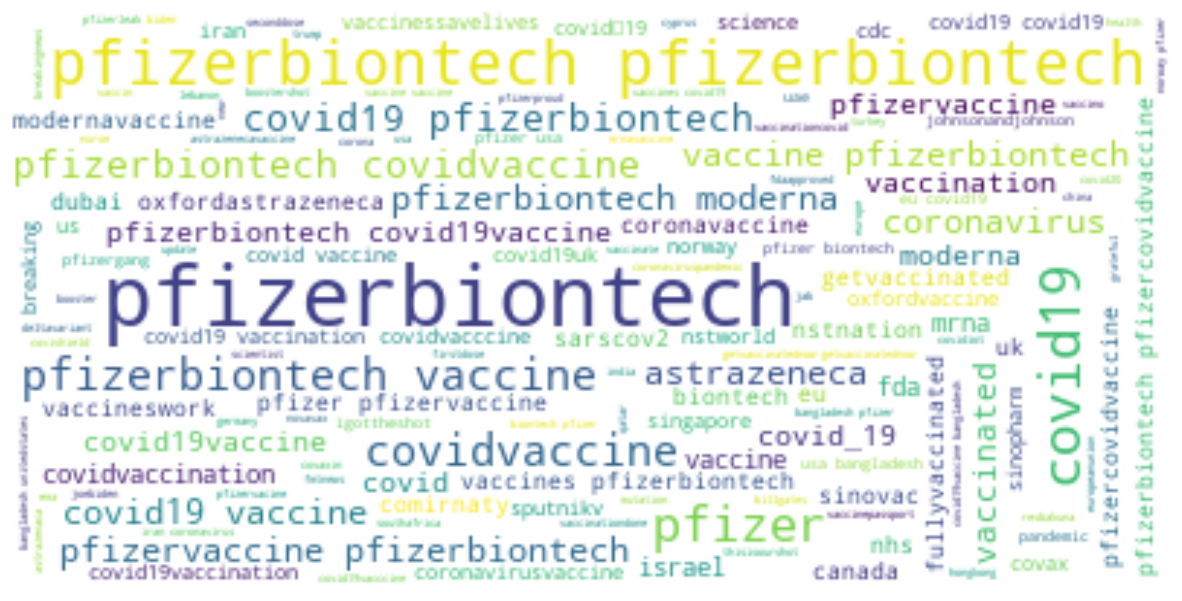

In [13]:
text = " ".join(i for i in df1.hashtag)
stopwords = set(STOPWORDS)
stopwords.add('HASHTAG')
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

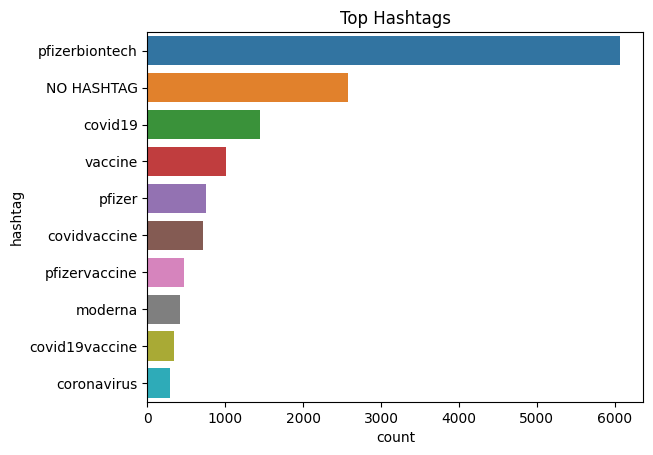

In [14]:
fig=sns.barplot(
    x=ds.head(10)['count'],
    y=ds.head(10)['hashtag'],
    orient='horizontal'
).set_title('Top Hashtags')


In [15]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df["text"] = df["text"].apply(clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itsma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\itsma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
sentiments=SentimentIntensityAnalyzer()
df['Pos']=[sentiments.polarity_scores(i)['pos'] for i in df['text']]
df['Neg']=[sentiments.polarity_scores(i)['neg'] for i in df['text']]
df['Neu']=[sentiments.polarity_scores(i)['neu'] for i in df['text']]

df=df[['text','Pos','Neg','Neu']]
print(df.head())

                                                text    Pos    Neg    Neu
0  folk said daikon past could treat cytokin stor...  0.252  0.000  0.748
1  world wrong side histori year hope biggest vac...  0.193  0.207  0.600
2  coronavirus sputnikv astrazeneca pfizerbiontec...  0.000  0.000  1.000
3  fact immut senat even your ethic sturdi enough...  0.000  0.000  1.000
4  explain need vaccin borisjohnson matthancock w...  0.000  0.000  1.000


In [19]:
import re
### Now create sentiment for each tweet using VADER.
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
#nltk.download('vader_lexicon')

df2 = pd.read_csv('vaccination_tweets.csv').fillna('')

def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text
    


df2['text'] = df2['text'].apply(lambda x:clean(x))
analyser = SentimentIntensityAnalyzer()
scores=[]
for i in range(len(df2['text'])):
    
    score = analyser.polarity_scores(df2['text'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df2['Sentiment']=pd.Series(np.array(sentiment))

Neutral     4816
Positive    4393
Negative    1811
Name: Sentiment, dtype: int64


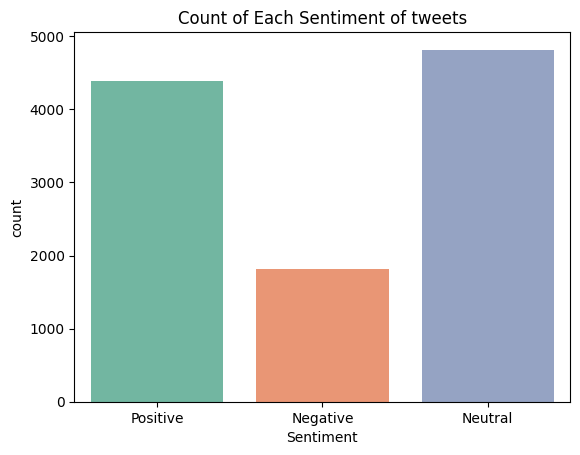

In [20]:
sns.countplot(x="Sentiment", data=df2, palette="Set2" )
plt.title("Count of Each Sentiment of tweets")
print(df2.Sentiment.value_counts())

In [21]:
x = sum(df["Pos"])
y = sum(df["Neg"])
z = sum(df["Neu"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [22]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  1015.070999999998
Negative:  443.2460000000005
Neutral:  9561.695999999913
